## Embedding of IPF cells

This notebook subsets all data to IPF related datasets, and the core, to explore the cell types and their uncertainty associated to disease. We take the scArches embedding and explore uncertainty of label transfer at level 4.

#### Structure

* [Global variables and paths](#bullet1)
* [Loading data](#bullet2)
* [Pre-processing](#bullet3)
* [Main](#bullet4)
* [Conclusions](#bullet5)
* [Save](#bullet6)

### Environment setup

In [ ]:
%load_ext autoreload
%autoreload 2
import importlib

spam_spec = importlib.util.find_spec("lab_black")
if spam_spec is not None:
    %load_ext lab_black

In [ ]:
# basic modules
import os, re, time
import sys, warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [ ]:
# in-house/developing modules
# tools modules
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sc.logging.print_versions()

In [ ]:
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(7, 7))

### Global variables and paths

We need the scArches embedding and the transfered labels. We will output an object with the UMAP calculated from the IPF subset.

In [ ]:
embed_inp = "../../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"
embed_out = (
    "../../../data/HLCA_extended/extension_disease/scarches_emb_ipf_all-celltypes.h5ad"
)
annot_inp = "../../../results/HLCA_ext_label_transfer/transfered_labels_query_only.csv"
celltypes_labels = "transf_ann_level_5"

In [ ]:
sc.settings.figdir = "figures/single-disease_" + re.sub(
    ".*/|scarches_emb_|.h5ad", "", embed_out
)
sc.settings.figdir

### Loading data <a class="anchor" id="bullet2"></a>

In [ ]:
embed = sc.read(embed_inp)

In [ ]:
embed

Let's check the diseases. We will take the IPF later in this notebook.

In [ ]:
temp = list(
    set(embed.obs.condition.cat.categories)
    - set(["Healthy (tumor adjacent)", "Healthy"])
)
sc.pl.umap(
    embed, color="condition", groups=temp, size=7, frameon=False, wspace=0.6, title=""
)

In [ ]:
del embed.uns
del embed.obsm
del embed.obsp

Now we load the transfered labels.

In [ ]:
annot_pred = pd.read_csv(annot_inp, index_col=0)

In [ ]:
annot_pred

### Pre-processing <a class="anchor" id="bullet3"></a>

#### Sorting missing/messy labels

Checking if the extension datasets have their labels transferred.

In [ ]:
index_intersect = list(set(embed.obs.index) & set(annot_pred.index))
print("Intersection with prediction:", len(index_intersect))
embed.obs.core_or_extension.value_counts()

In [ ]:
embed.obs = pd.concat([embed.obs, annot_pred.loc[index_intersect, :]], axis=1)

Adding the labels used to do the transfer to their respective [transferred] columns.

In [ ]:
for column_i in list(
    filter(re.compile(r"transf_ann_level_._label").search, embed.obs.columns)
):
    print("--------------------", column_i)
    embed.obs[column_i] = embed.obs[column_i].astype(str)
    embed.obs[re.sub("transf_|_label", "", column_i)] = embed.obs[
        re.sub("transf_|_label", "", column_i)
    ].astype(str)
    temp = embed.obs[column_i] == "nan"
    embed.obs["celltype"] = embed.obs[column_i]
    embed.obs.loc[temp, "celltype"] = embed.obs.loc[
        temp, re.sub("transf_|_label", "", column_i)
    ]
    embed.obs[column_i] = embed.obs["celltype"]

In [ ]:
embed.obs[
    [column_i, re.sub("transf_|_label", "", column_i), "celltype", "core_or_extension"]
]

We will only be taking the subjects from IPF datasets (diseased and healthy) along with the [healthy] core.

In [ ]:
condition_renamer = {i: i for i in embed.obs.condition.cat.categories}
condition_renamer["End-stage lung fibrosis, unknown etiology"] = "IPF"
condition_renamer["Healthy (tumor adjacent)"] = "Healthy"
embed.obs["condition"] = embed.obs.condition.map(condition_renamer)

There are two samples (one subject) in the Schiller_2020 data that are End-stage Fibrosis but not IPF.

In [ ]:
schiller_subjects = (
    embed.obs.loc[embed.obs.study == "Schiller_2020"]
    .subject_ID.astype(str)
    .unique()
    .tolist()
)
schiller_subjects = set(schiller_subjects) - set(["muc8257", "muc8258"])

Barbry_unpubl is discarded because of the poor gene overlap with the core.

In [ ]:
embed_ext_obs = embed.obs.loc[embed.obs.core_or_extension == "extension", :]
df = pd.crosstab(embed_ext_obs.study, embed_ext_obs.condition)
dsets = list(
    set(df.loc[df.IPF > 0].index.tolist()) - set(["Barbry_unpubl", "Schiller_2020"])
)
dsets.append("Schiller_2020")
dsets

Schiller is at the end of the list in this case and so it's used to discard the two samples that are not IPF.

Also including the core.

In [ ]:
embed_disease_obs = embed.obs[
    embed.obs.study.isin(dsets[:-1])
    & embed.obs.condition.isin(["Healthy", "Healthy (tumor adjacent)", "IPF"])
    | (embed.obs.study.isin(dsets[-1:]) & embed.obs.subject_ID.isin(schiller_subjects))
    | (embed.obs["core_or_extension"] == "core")
].copy()

In [ ]:
pd.crosstab(embed_disease_obs.study, embed_disease_obs.condition)

We are taking all celltypes this time.

In [ ]:
pd.crosstab(embed_disease_obs.study, embed_disease_obs.condition)

In [ ]:
embed_disease = embed[embed_disease_obs.index].copy()

In [ ]:
embed_disease

Checking if all celltypes are well represented.

In [ ]:
temp = embed_disease.obs.transf_ann_level_4_label.value_counts()
pd.set_option("display.max_rows", len(temp))
temp

### Main <a class="anchor" id="bullet4"></a>

Calculate UMAP.

We calculate the nearest neighbors graph for our new UMAP and clustering of IPF datasets.

In [ ]:
%%time
sc.pp.neighbors(embed_disease, n_neighbors=30)

In [ ]:
%%time
sc.tl.umap(embed_disease)

In [ ]:
sc.pl.umap(
    embed_disease,
    color="core_or_extension",
    frameon=False,
    size=7,
    wspace=0.6,
    title="",
)

In [ ]:
sc.pl.umap(embed_disease, color="study", size=7, frameon=False, wspace=0.6, title="")

Checking by core, extension_healthy, and extension_disease.

In [ ]:
%%time
temp = list()
for i in embed_disease.obs.index:
    if embed_disease.obs.loc[i, "condition"] == "IPF":
        temp.append(embed_disease.obs.loc[i, "core_or_extension"] + "_disease")
    elif embed_disease.obs.loc[i, "core_or_extension"] == "extension":
        temp.append(embed_disease.obs.loc[i, "core_or_extension"] + "_healthy")
    else:
        temp.append(embed_disease.obs.loc[i, "core_or_extension"])
embed_disease.obs["reference_condition"] = temp

### Cell types visualization

In [ ]:
index_list = embed_disease.obs.index.tolist()
np.random.shuffle(index_list)
embed_disease = embed_disease[index_list, :]

In [ ]:
cluster_columns = [
    "celltypes",
    "transf_ann_level_4_label",
    "transf_ann_level_5_label",
]
obs_columns = list(
    set(
        [
            "dataset",
            "reference_condition",
            "condition",
            "core_or_extension",
        ]
    )
    & set(embed_disease.obs.columns)
)

In [ ]:
temp = obs_columns + cluster_columns
for i in temp:
    ax = sc.pl.umap(
        embed_disease,
        color=i,
        size=7,
        frameon=False,
        wspace=0.6,
        return_fig=True,
    )
    fname_file = str(sc.settings.figdir) + "/umap_ob_" + i + ".png"
    print(f"Saving to: {fname_file}")
    plt.savefig(
        fname=fname_file,
        bbox_inches="tight",
        transparent=True,
    )

Let's check the uncertainty distribution on the UMAP.

In [ ]:
sc.pl.umap(
    adata=embed_disease,
    color=[
        "transf_ann_level_2_uncert",
        "transf_ann_level_3_uncert",
        "transf_ann_level_4_uncert",
        "transf_ann_level_5_uncert",
    ],
    size=7,
    frameon=False,
    wspace=0.6,
    ncols=2,
)

#### Selected annotation level

In [ ]:
embed_disease.obs["celltypes"] = [
    i if i != i else re.sub(".*_", "", i) for i in embed_disease.obs[celltypes_labels + "_label"]
]

Getting IPF datasets

In [ ]:
df = pd.crosstab(embed_disease.obs.study, embed_disease.obs.condition)
df
dsets = list(
    set(df.loc[df.IPF > 0].index.tolist()) - set(["Barbry_unpubl", "Schiller_2020"])
)
dsets.append("Schiller_2020")
dsets

condition,Healthy,IPF
study,,
Banovich_Kropski_2020,121894,57668
Barbry_Leroy_2020,74487,0
Jain_Misharin_2021,45557,0
Kaminski_2020,95303,144404
Krasnow_2020,60982,0
Lafyatis_Rojas_2019,24181,0
Meyer_2019,35554,0
Misharin_2021,64843,0
Misharin_Budinger_2018,41220,15517


['Misharin_Budinger_2018',
 'Sheppard_2020',
 'Banovich_Kropski_2020',
 'Kaminski_2020',
 'Schiller_2020']

In [ ]:
embed_disease_e = embed_disease[embed_disease.obs.dataset.isin(dsets)].copy()
ct_counts = embed_disease_e.obs["celltypes"].value_counts()
ct_to_remove = ct_counts[ct_counts < 20].index.tolist()
embed_disease_e.obs["celltypes_clean"] = embed_disease_e.obs["celltypes"].astype(str)
embed_disease_e.obs.loc[
    embed_disease_e.obs["celltypes"].isin(ct_to_remove),
    "celltypes_clean",
] = "Other"

Checking uncertainty values

In [ ]:
pd.crosstab(embed_disease_e.obs.study, embed_disease_e.obs.condition)
embed_disease_e.obs.groupby(["study", "core_or_extension"])[celltypes_labels + "_uncert"].mean()

condition,Healthy,IPF
study,,
Banovich_Kropski_2020,121894,57668
Kaminski_2020,95303,144404
Misharin_Budinger_2018,41220,15517
Schiller_2020,21122,8400
Sheppard_2020,27786,33817


study                   core_or_extension
Banovich_Kropski_2020   core                      NaN
                        extension            0.145960
Kaminski_2020           core                      NaN
                        extension            0.203882
Misharin_Budinger_2018  core                      NaN
                        extension            0.144572
Schiller_2020           core                      NaN
                        extension            0.124362
Sheppard_2020           core                      NaN
                        extension            0.181476
Name: transf_ann_level_5_uncert, dtype: float64

Calculate uncertainties for healthy and IPF samples separately:

In [ ]:
uncerts_ts_group = (
    embed_disease_e.obs.groupby(["celltypes_clean", "condition"])
    .agg({celltypes_labels + "_uncert": "mean", "condition": "count"})
    .unstack()
).droplevel(axis=1, level=0)
uncerts_ts_group

condition,Healthy,IPF,Healthy,IPF
celltypes_clean,,,,
AT0,0.344987,0.430677,96,925
AT1,0.052865,0.184763,1573,856
AT2,0.028623,0.092439,8546,8942
AT2 proliferating,0.135550,0.250079,109,95
Adventitial fibroblasts,0.146072,0.236039,2627,6002
Alveolar Mph CCL3+,0.371908,0.334163,2911,1898
Alveolar Mph MT-positive,0.420183,0.421715,330,475
Alveolar Mph proliferating,0.159966,0.178249,417,2244
Alveolar fibroblasts,0.038987,0.282574,11313,5085


In [ ]:
uncerts_ts_group.columns = ["Healthy_unc", "IPF_unc", "Healthy_ncells", "IPF_ncells"]

Calculate the order by the biggest difference.

In [ ]:
diff_uncerts = uncerts_ts_group.IPF_unc - uncerts_ts_group.Healthy_unc
# drop cell types that aren't present in both
diff_uncerts_filt = diff_uncerts.loc[
    [
        (suff_h and suff_i)
        for suff_h, suff_i in zip(
            uncerts_ts_group.Healthy_ncells > 10, uncerts_ts_group.IPF_ncells > 10
        )
    ]
].copy()

In [ ]:
order_violin = diff_uncerts_filt.sort_values(ascending=False).index

In [ ]:
plt.rcParams["figure.figsize"] = (10, 3)

Let's check it aggregate across all datasets first.

Saving to : figures/single-disease_ipf_all-celltypes/violin_10celltypes_aggr-dataset.png


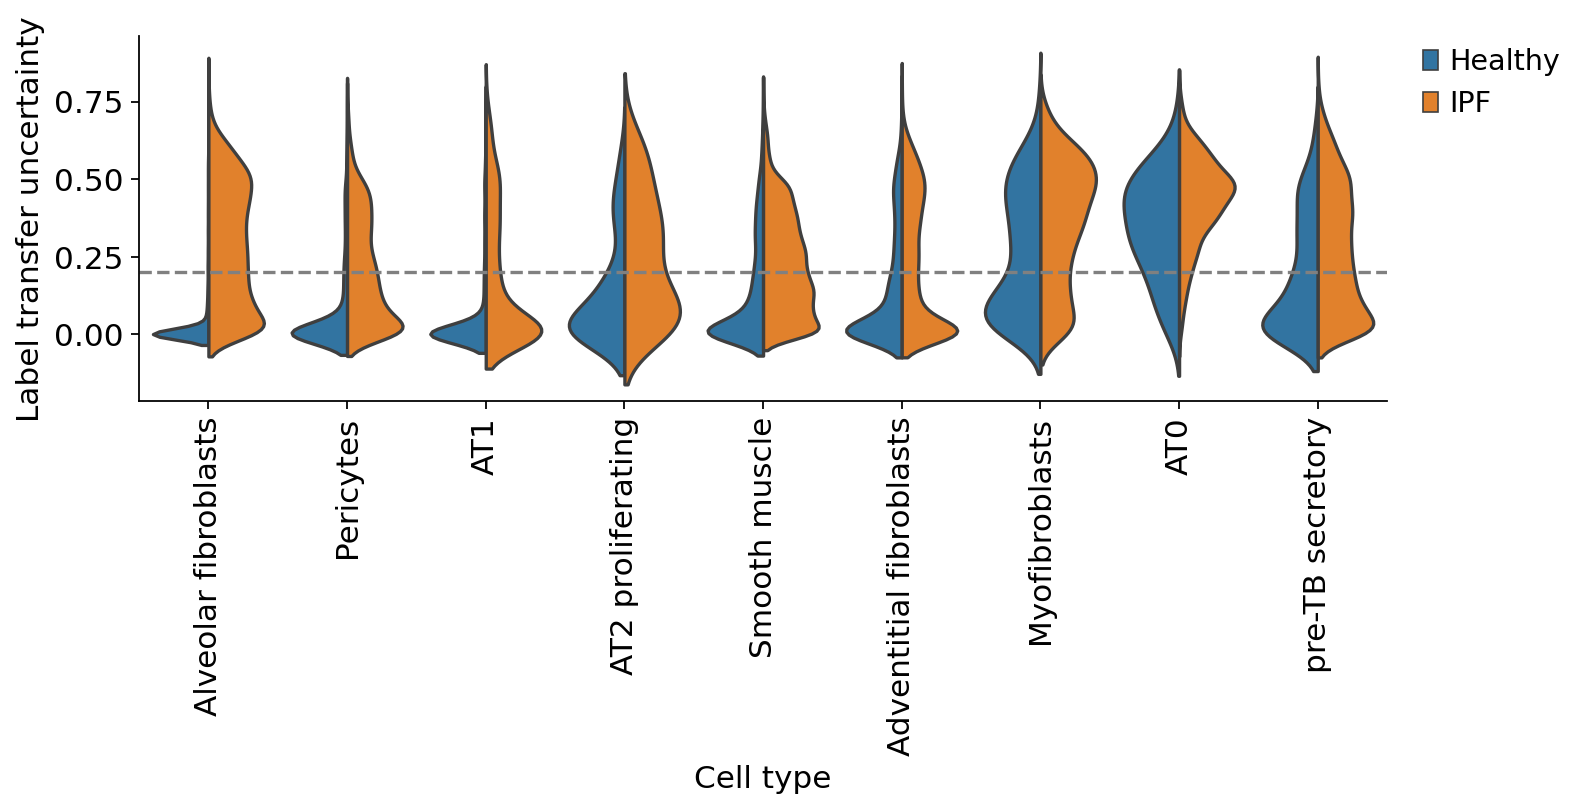

In [ ]:
fig, ax = plt.subplots()
sns.violinplot(
    x=embed_disease_e.obs["celltypes_clean"],
    y=embed_disease_e.obs[celltypes_labels + "_uncert"],
    hue=embed_disease_e.obs.condition,
    split=True,
    inner=None,
    order=order_violin[:9],
    scale="width",
    ax=ax,
    palette={"Healthy": "tab:blue", "IPF": "tab:orange"},
)
ax.axhline(
    0.2,
    linestyle="dashed",
    color="grey",
)
ax.set(xlabel="Cell type", ylabel="Label transfer uncertainty")
ax.tick_params("x", rotation=90)
ax.grid(False)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, frameon=False)
sns.despine()
file_name = str(sc.settings.figdir) + "/violin_10celltypes_aggr-dataset.png"
print(f"Saving to : {file_name}")
plt.savefig(fname=file_name, bbox_inches="tight", transparent=True)

Now by dataset (aggregated all cell types).

Saving to: figures/single-disease_ipf_all-celltypes/violin_10celltypes_per-dataset.png


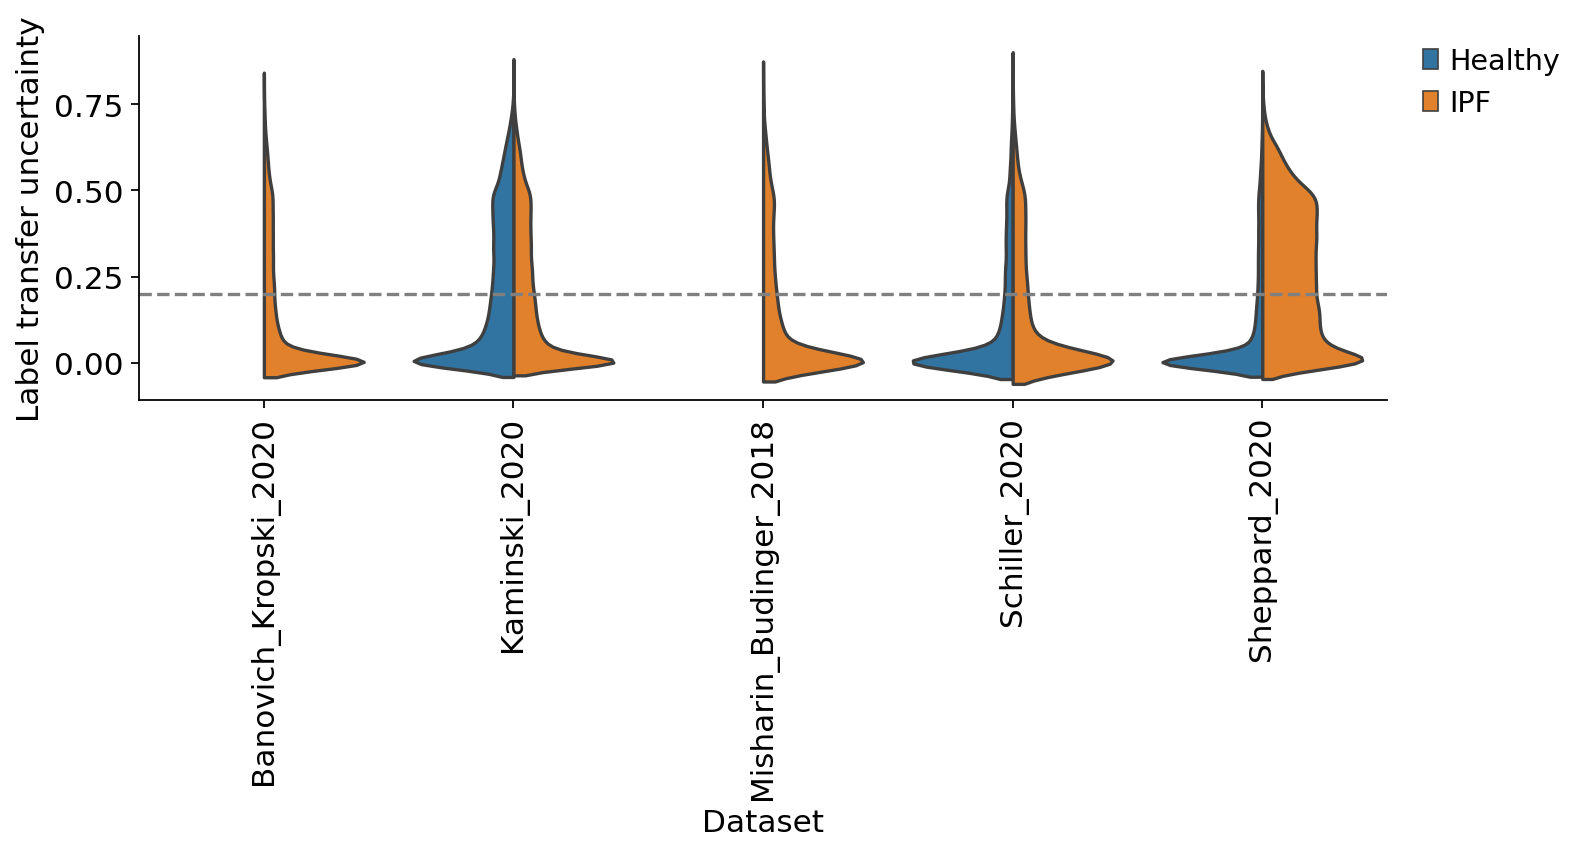

In [ ]:
fig, ax = plt.subplots()
sns.violinplot(
    x=embed_disease_e.obs.dataset,
    y=embed_disease_e.obs[celltypes_labels + "_uncert"],
    hue=embed_disease_e.obs.condition,
    split=True,
    inner=None,
    scale="width",
    ax=ax,
    palette={"Healthy": "tab:blue", "IPF": "tab:orange"},
)
ax.axhline(
    0.2,
    linestyle="dashed",
    color="grey",
)
ax.set(xlabel="Dataset", ylabel="Label transfer uncertainty")
ax.tick_params("x", rotation=90)
ax.grid(False)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, frameon=False)
sns.despine()
file_name = str(sc.settings.figdir) + "/violin_10celltypes_per-dataset.png"
print(f"Saving to: {file_name}")
plt.savefig(fname=file_name, bbox_inches="tight", transparent=True)

You can see some of the studies don't have uncertainty for the healthy part because that's in the core, which was used for label transfer.

In [ ]:
plt.rcParams["figure.figsize"] = (14, 10)

Finally, let's have a look at each cell type separating datasets to evaluate if differences are consistent accross datasets.

Saving to: figures/single-disease_ipf_all-celltypes/violin_all-celltypes_per-dataset.png


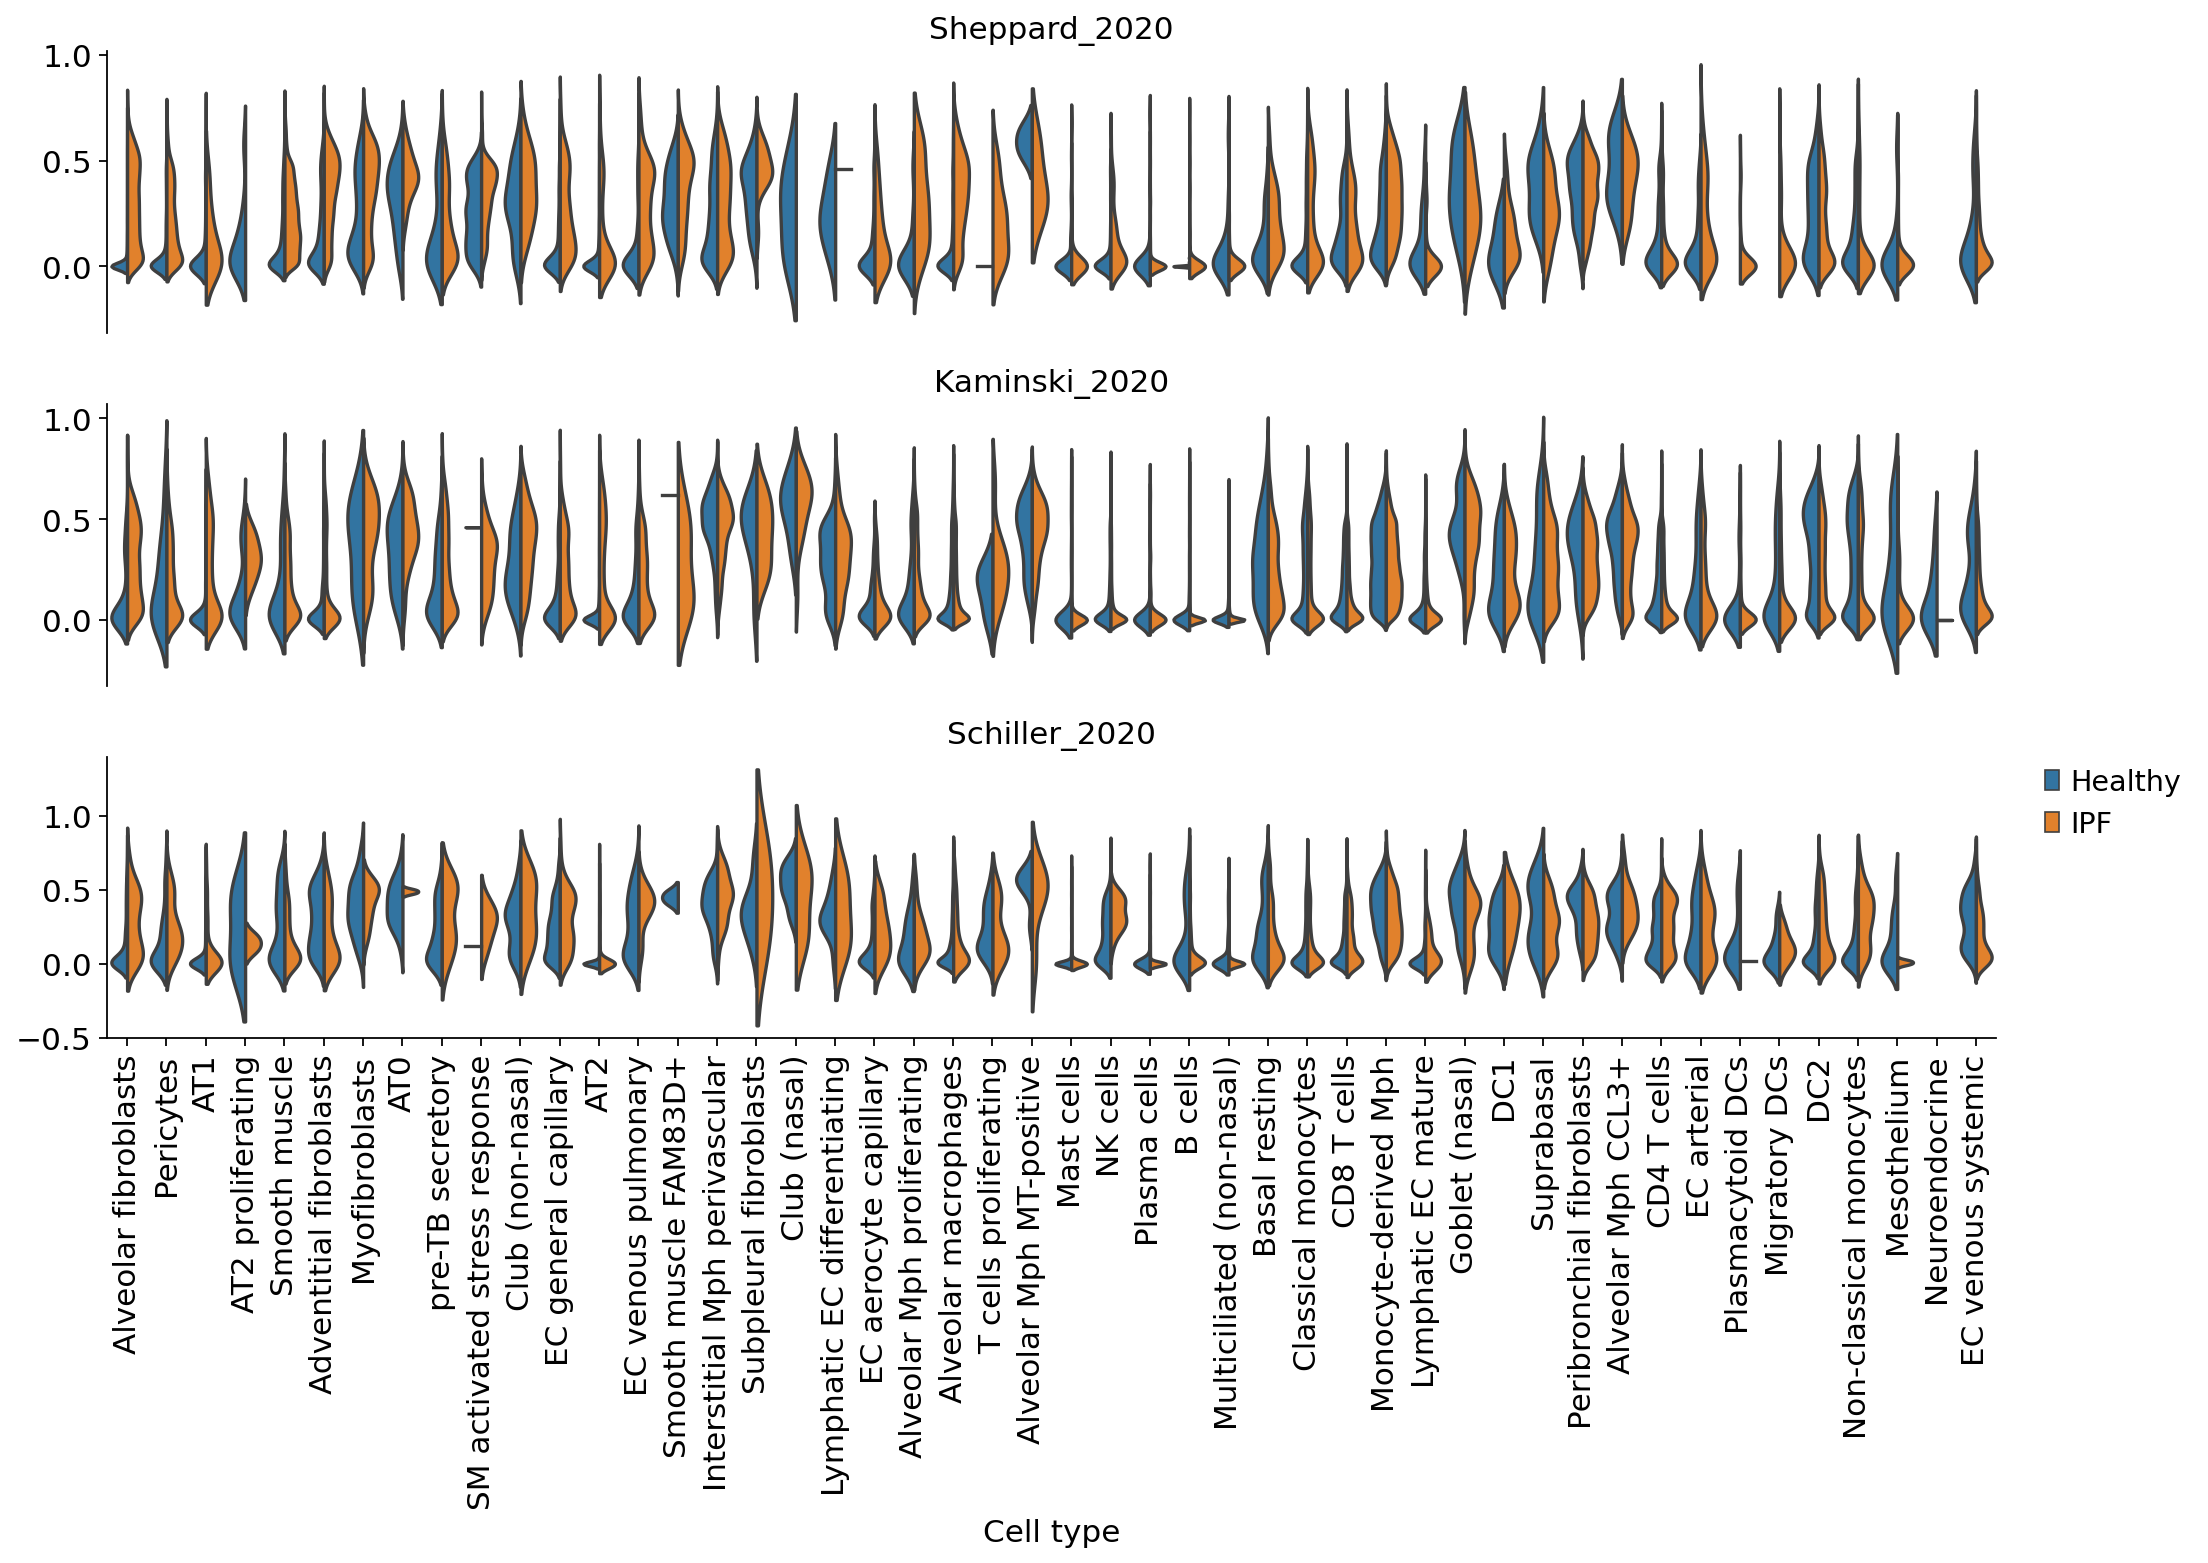

In [ ]:
df0 = embed_disease_e.obs.copy()
qc_obs = [
    "Sheppard_2020",
    "Kaminski_2020",
    # 'Misharin_Budinger_2018', # no uncertainty calculation for core
    # 'Banovich_Kropski_2020', # no uncertainty calculation for core
    "Schiller_2020",
]  # df0.dataset.cat.categories
pl_obs = [
    "celltypes_clean",
    celltypes_labels + "_uncert",
    "condition",
]
df0[pl_obs[0]] = df0[pl_obs[0]].astype("category")
df0[pl_obs[2]] = df0[pl_obs[2]].astype("category")
all_refs = list(df0[pl_obs[2]].cat.categories)
all_ctyp = list(df0[pl_obs[0]].cat.categories)
nrows_i = 3
ncols_i = 1
i = 0
fig, axs = plt.subplots(nrows=nrows_i, ncols=ncols_i)
for j in range(nrows_i):
    for k in range(ncols_i):
        if (len(qc_obs) - 1) >= i:
            df = df0.loc[df0.dataset == qc_obs[i], pl_obs]
            df[pl_obs[0]] = df[pl_obs[0]].cat.set_categories(all_ctyp)
            df[pl_obs[2]] = df[pl_obs[2]].cat.set_categories(all_refs)
            sns.violinplot(
                x=df[pl_obs[0]],
                y=df[pl_obs[1]],
                hue=df[pl_obs[2]],
                split=len(df[pl_obs[2]].cat.categories) > 1,
                order=order_violin,
                inner=None,
                scale="width",
                ax=axs[j],
                palette={
                    "Healthy": "tab:blue",
                    "IPF": "tab:orange",
                },
            )
            if j == (nrows_i - 1):
                axs[j].set(xlabel="Cell type")
                axs[j].set(ylabel="Label transfer uncertainty")
                if k == (ncols_i - 1):
                    axs[j].set(ylabel=None)
                    axs[j].legend(
                        bbox_to_anchor=(1.02, 1),
                        loc="upper left",
                        borderaxespad=0,
                        frameon=False,
                    )
                else:
                    axs[j].legend([], [], frameon=False)
                axs[j].tick_params("x", rotation=90)
                axs[j].grid(False)
                sns.despine(ax=axs[j])
            else:
                axs[j].set(xlabel=None, ylabel=None)
                axs[j].tick_params(bottom=False)
                axs[j].grid(False)
                axs[j].legend([], [], frameon=False)
                sns.despine(bottom=True, ax=axs[j])
                axs[j].set(xticklabels=[])
            axs[j].set_title(qc_obs[i])
            i += 1
file_name = str(sc.settings.figdir) + "/violin_all-celltypes_per-dataset.png"
print(f"Saving to: {file_name}")
plt.tight_layout()
plt.savefig(fname=file_name, bbox_inches="tight", transparent=True)

### Save <a class="anchor" id="bullet6"></a>

In [ ]:
embed_disease.write(filename=embed_out)

Done.